In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch

In [11]:
def sparse(tnsr, sparsity, mean=0.0, std=1.0, generator=None):
    if tnsr.ndimension() != 2:
        raise ValueError("Only tensors with 2 dimensions are supported")

    if not (generator is None):
        device = generator.device
    else:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')

    rows, cols = tnsr.shape
    num_zeros = int(np.ceil(sparsity * rows))

    with torch.no_grad():
        device_cpu = torch.device('cpu')
        m = torch.from_numpy(np.array(mean)).to(device_cpu)
        std = torch.from_numpy(np.array(std)).to(device_cpu)
        (rows, cols) = (torch.tensor(rows).to(device_cpu), torch.tensor(cols).to(device_cpu))
        # it seems it can only use generator on CPU?
        generator_cpu = torch.Generator(device=torch.device(device_cpu))
        if not (generator is None):
            generator_cpu.manual_seed(int(generator.initial_seed()))
        else:
            generator_cpu.manual_seed(np.random.randint(100000))
        # first create tensor on CPU then move it to gpu
        tnsr = torch.normal(m, std, (rows, cols), generator=generator_cpu).to(device)

        for col_idx in range(cols):
            row_indices = torch.randperm(rows, generator=generator, device=device)
            zero_indices = row_indices[:num_zeros]
            tnsr[zero_indices, col_idx] = 0
    return tnsr

def channel_overlap_penalty(W_inp):
    b = W_inp
    b = b / (torch.linalg.vector_norm(b, dim=0) + 1e-12)
    G = torch.tril(b.T @ b, diagonal=-1)
    lower_tri_mask = torch.tril(torch.ones_like(G), diagonal=-1)
    return torch.sqrt(torch.mean(G[lower_tri_mask == 1.0] ** 2))

In [9]:
N = 100
mu_E = 1 / np.sqrt(N)
std = 1 / N
num_inputs = 6
input_sparsity = 0
W_inp = torch.abs(sparse(torch.zeros([N, num_inputs]).float(), input_sparsity, mu_E, std)).float()

In [20]:
Ns = np.logspace(1, 6, num=16, dtype=int)  # From 10 to 10000
num_inputs_list = [3, 6, 12, 20]
num_trials = 101

penalties = {k: [] for k in num_inputs_list}

for num_inputs in num_inputs_list:
    for N in Ns:
        penalties_this_N = []
        mu_E = 1 / np.sqrt(N)
        std = 1 / N
        for _ in range(num_trials):
            W_inp = torch.abs(sparse(torch.zeros([N, num_inputs]).float(), 0, mu_E, std)).float()
            penalty = channel_overlap_penalty(W_inp)
            penalties_this_N.append(penalty)
        penalties[num_inputs].append((np.mean(penalties_this_N), np.std(penalties_this_N)))

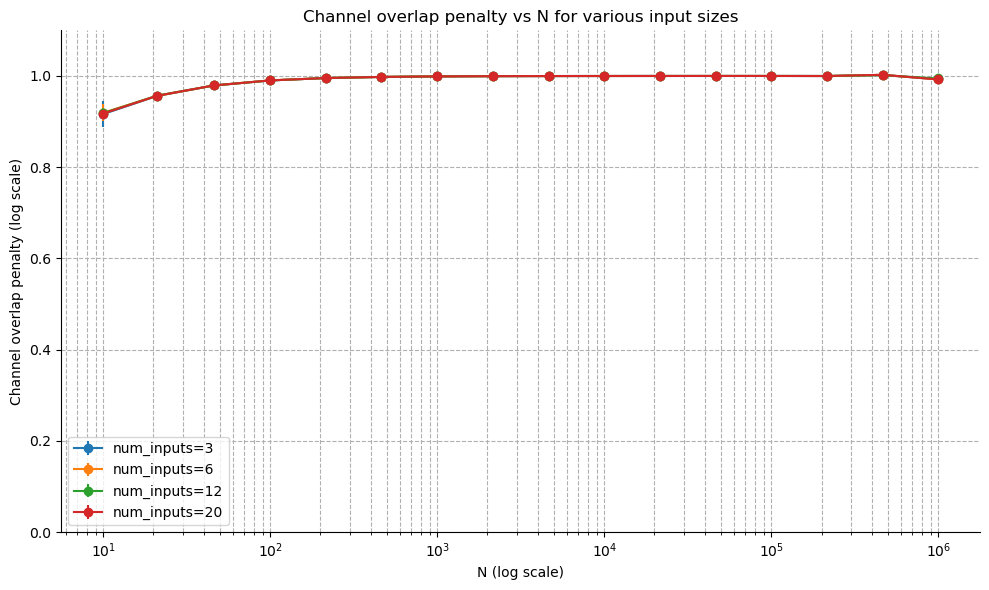

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for num_inputs in num_inputs_list:
    means = [m for m, s in penalties[num_inputs]]
    stds = [s for m, s in penalties[num_inputs]]
    ax.errorbar(Ns, means, yerr=stds, label=f'num_inputs={num_inputs}', marker='o')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('N (log scale)')
ax.set_ylabel('Channel overlap penalty (log scale)')
plt.title('Channel overlap penalty vs N for various input sizes')
ax.legend()
ax.set_ylim([0, 1.1])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

Thereby, orthogonalization penalty does not need scaling with N

# Metabolic penalty: testing untrained networks

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from omegaconf import OmegaConf
import hydra
from trainRNNbrain.analyzers.PerformanceAnalyzer import PerformanceAnalyzer
from trainRNNbrain.utils import jsonify, unjsonify
from trainRNNbrain.training.training_utils import prepare_task_arguments, get_training_mask, prepare_RNN_arguments
import torch
from tqdm.auto import tqdm


In [2]:
OmegaConf.register_new_resolver("eval", eval)

In [3]:
import hydra
from omegaconf import DictConfig, OmegaConf

# Set up config path (should point to directory, not file)
with hydra.initialize(version_base=None, config_path="../configs"):
    # Compose the config (config_name should match a file in configs/, e.g. config.yaml)
    cfg: DictConfig = hydra.compose(config_name="base", overrides=[])

# print(OmegaConf.to_yaml(cfg))
# print(cfg)

In [4]:
taskname = cfg.task.taskname
tag = f"relu_constrained=constrained"
print(f"training {taskname}, {tag}")

# defining the task
task_conf = prepare_task_arguments(cfg_task=cfg.task, dt=cfg.model.dt)
task = hydra.utils.instantiate(task_conf)
input_batch, target_batch, conditions_batch = task.get_batch(shuffle=False)
input_batch = torch.from_numpy(input_batch.astype("float32"))
target_batch = torch.from_numpy(target_batch.astype("float32"))

training CDDM, relu_constrained=constrained


In [5]:
rnn_config = prepare_RNN_arguments(cfg_task=cfg.task, cfg_model=cfg.model)
rnn_torch = hydra.utils.instantiate(rnn_config)

Using cpu for RNN!


/Users/tolmach/Documents/GitHub/trainRNNbrain/trainRNNbrain/rnns/RNN_torch_wStepwiseDO.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W_rec = torch.tensor(radius / spec_radius).to(device=device) * W_rec.to(device=device)


In [6]:
states, outputs = rnn_torch(input_batch)

In [7]:
# List of N to try
Ns = np.logspace(1, 3, num=10, dtype=int)  # e.g., [10, 22, 46, ..., 1000]
num_trials = 11  # Lower if big N for speed!

# metrics = {'q10': [], 'q50': [], 'q90': [], 'L1': [], 'L2': []}
metrics = {'median': [], 'L1': [], 'L2': []}
metrics_std = {k: [] for k in metrics}

with hydra.initialize(version_base=None, config_path="../configs"):
    # Compose the config (config_name should match a file in configs/, e.g. config.yaml)
    cfg: DictConfig = hydra.compose(config_name="base", overrides=[])

    taskname = cfg.task.taskname
    tag = f"relu_constrained=constrained"
    print(f"training {taskname}, {tag}")
    
    # defining the task
    task_conf = prepare_task_arguments(cfg_task=cfg.task, dt=cfg.model.dt)
    task = hydra.utils.instantiate(task_conf)
    input_batch, target_batch, conditions_batch = task.get_batch(shuffle=False)
    input_batch = torch.from_numpy(input_batch.astype("float32"))
    target_batch = torch.from_numpy(target_batch.astype("float32"))

    rnn_config = prepare_RNN_arguments(cfg_task=cfg.task, cfg_model=cfg.model)
    
    for N in tqdm(Ns):
        # q10_list, q50_list, q90_list, L1_list, L2_list = [], [], [], [], []
        median_list, L1_list, L2_list = [], [], []
        for _ in range(num_trials):
            rnn_config.N = int(N)  # Set network size in config
            rnn_torch = hydra.utils.instantiate(rnn_config)
            states, outputs = rnn_torch(input_batch)  # states shape: (N, T, B)
            abs_states = states.detach().abs().cpu().numpy().reshape(N, -1)
            # q10_list.append(np.percentile(abs_states, 10))
            median_list.append(np.percentile(abs_states, 50) * N)
            # q90_list.append(np.percentile(abs_states, 90))
            L1_list.append(np.sum(abs_states))
            L2_list.append(np.sqrt(np.sum(abs_states ** 2)))

        # metrics['q10'].append(np.mean(q10_list))
        metrics['median'].append(np.mean(median_list))
        # metrics['q90'].append(np.mean(q90_list))
        metrics['L1'].append(np.mean(L1_list))
        metrics['L2'].append(np.mean(L2_list))

        # metrics_std['q10'].append(np.std(q10_list))
        metrics_std['median'].append(np.std(median_list))
        # metrics_std['q90'].append(np.std(q90_list))
        metrics_std['L1'].append(np.std(L1_list))
        metrics_std['L2'].append(np.std(L2_list))

training CDDM, relu_constrained=constrained


  0%|          | 0/10 [00:00<?, ?it/s]

Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu for RNN!
Using cpu fo

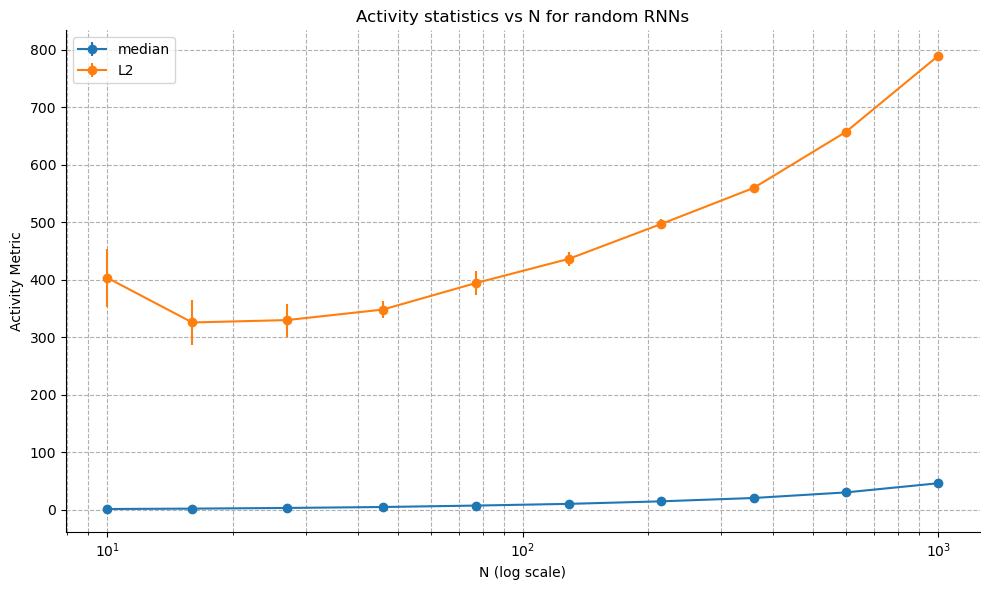

In [10]:
# --- Plotting ---

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for metric in ['median', 'L2']:
# for metric in ['L1']:
    means = metrics[metric]
    stds = metrics_std[metric]
    ax.errorbar(Ns, means, yerr=stds, label=metric, marker='o')

ax.set_xscale('log')
ax.set_xlabel('N (log scale)')
ax.set_ylabel('Activity Metric')
plt.title('Activity statistics vs N for random RNNs')
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()
